In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import plot_model
import sklearn
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
from numpy.random import seed
#set_random_seed(1)
seed(1)

train = pd.read_csv('TestData/train.csv',',')
predTest = pd.read_csv('TestData/testData.csv',';')
#train = pd.read_csv('TestData/TrainingData_8Weeks.csv',';' , parse_dates=['Time'])

train.describe()

,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
count,17626.000000,1.762600e+04,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.00000,17626.000000,17626.000000
mean,84.995723,7.582117e+08,35.159197,3.951265,8.807599,10.314143,220.348746,21.83791,4.367582,4440.145013
std,17.860778,1.582321e+08,16.162640,1.927908,1.017044,0.850116,87.248204,8.70554,1.741108,2186.389034
min,20.573511,1.921125e+08,7.000000,0.000000,2.790000,7.230000,145.000000,15.00000,3.000000,1475.000000
25%,77.667220,7.000179e+08,24.000000,3.000000,8.270000,9.730000,153.000000,15.00000,3.000000,2802.000000
50%,92.715866,8.244681e+08,30.000000,4.000000,8.950000,10.260000,197.000000,20.00000,4.000000,3790.500000
75%,97.449125,8.703534e+08,42.000000,5.000000,9.480000,10.850000,255.000000,25.00000,5.000000,5600.750000
max,104.246370,9.245294e+08,91.000000,12.000000,11.480000,13.280000,442.000000,45.00000,9.000000,14855.000000


In [2]:
train

,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
0,25.31369,284485100,24,3,8.50,10.36,145,15,3,1808
1,25.31369,284485100,24,3,8.50,10.36,145,15,3,1525
2,25.31369,284485100,24,3,8.50,10.36,200,20,4,2735
3,25.31369,284485100,24,3,8.50,10.36,200,20,4,2248
4,25.31369,284485100,24,3,8.50,10.36,147,15,3,2056
...,...,...,...,...,...,...,...,...,...,...
17621,101.64704,888701300,16,2,5.88,11.96,150,15,3,1860
17622,101.26033,897286900,19,4,6.30,11.62,156,15,3,2284
17623,101.26033,897286900,19,4,6.30,11.62,197,20,4,2026
17624,101.26033,897286900,19,4,6.30,11.62,255,25,5,2555


In [3]:
split_fraction = 0.70
train_split = int(split_fraction * int(train.shape[0]))
step = 1

#past = 0
#future = 8
learning_rate = 0.0005
batch = 256
epochs = 100
mean = 0
std = 0

def normalize(data, train_split):
    global mean
    global std
    data_mean = data[:train_split].mean(axis=0)
    mean = data_mean
    data_std = data[:train_split].std(axis=0)
    std = data_std
    return (data - data_mean) / data_std

In [4]:
titles = []
for c in train.columns:
    titles.append(c);
    
features = train[titles]
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9
0,-3.212565,-2.875417,-0.778773,-0.532953,-0.344685,0.11669,-0.857361,-0.779658,-0.779658,-1.243078
1,-3.212565,-2.875417,-0.778773,-0.532953,-0.344685,0.11669,-0.857361,-0.779658,-0.779658,-1.362727
2,-3.212565,-2.875417,-0.778773,-0.532953,-0.344685,0.11669,-0.228713,-0.207005,-0.207005,-0.851154
3,-3.212565,-2.875417,-0.778773,-0.532953,-0.344685,0.11669,-0.228713,-0.207005,-0.207005,-1.057052
4,-3.212565,-2.875417,-0.778773,-0.532953,-0.344685,0.11669,-0.834501,-0.779658,-0.779658,-1.138227


In [5]:
train_data = features.loc[0 : train_split - 1] #Training Data
val_data = features.loc[train_split:] #Validation Data
val_data

,0,1,2,3,4,5,6,7,8,9
12338,-0.421817,-0.807672,-0.950513,-1.054079,0.267086,0.331029,0.377075,0.365647,0.365647,-0.434285
12339,-0.421817,-0.807672,-0.950513,-1.054079,0.267086,0.331029,-0.674482,-0.779658,-0.779658,-1.019846
12340,-0.421817,-0.807672,-0.950513,-1.054079,0.267086,0.331029,-0.765921,-0.779658,-0.779658,-0.967420
12341,-0.421817,-0.807672,-0.950513,-1.054079,0.267086,0.331029,-0.125844,-0.207005,-0.207005,-0.635532
12342,-0.421817,-0.807672,-0.950513,-1.054079,0.267086,0.331029,-0.125844,-0.207005,-0.207005,-0.772938
...,...,...,...,...,...,...,...,...,...,...
17621,0.978366,0.848436,-1.236746,-1.054079,-2.929912,2.021928,-0.800211,-0.779658,-0.779658,-1.221093
17622,0.957134,0.901350,-1.065006,-0.011827,-2.515486,1.617065,-0.731632,-0.779658,-0.779658,-1.041831
17623,0.957134,0.901350,-1.065006,-0.011827,-2.515486,1.617065,-0.263003,-0.207005,-0.207005,-1.150910
17624,0.957134,0.901350,-1.065006,-0.011827,-2.515486,1.617065,0.399935,0.365647,0.365647,-0.927256


In [6]:
#start = past + future
start = 0
end = start + train_split

x_train = train_data[[i for i in range(10)]].values
y_train = features.iloc[start:end][[9]]

#sequence_length = int(past / step)
sequence_length = 1

In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

In [8]:
label_start = train_split
valRange = int(train.shape[0]) - train_split

x_val = val_data.iloc[[i for i in range(valRange)]].values
# x_val = val_data.iloc[[i for i in range(49)]].values
y_val = features.iloc[label_start:][[9]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 1, 10)
Target shape: (256, 1)


In [9]:
# Long Short Term Memory - Model als Methodik mit Adam --> stochastic gradient descent algorithm

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(512, return_sequences=True)(inputs)
lstm_out1 = keras.layers.LSTM(512, return_sequences=True)(lstm_out)
# lstm_out2 = keras.layers.LSTM(512, return_sequences=True)(lstm_out1)
# lstm_out3 = keras.layers.LSTM(512)(lstm_out)
outputs = keras.layers.Dense(1)(lstm_out1)
learning_rate = 0.001
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#model.save("kerasModel")

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 10)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 512)            1071104   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 1, 1)              513       
Total params: 3,170,817
Trainable params: 3,170,817
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
path_checkpoint = "simpleModelCheckpoint.h5"

def scheduler(epoch, lr):
#     return 0.001
    if lr > 0.004:
        return lr - 0.0002
    else:
        if lr > 0.0004:
            return lr - 0.000001
        else:            
            return 0.0001
#     if epoch < 10:
#         return lr
#     else:
#         if lr < 0.002:
#             return lr - 0.00001
#         else:
#             return lr - 0.0015
#     if lr < 0.002:
#         return lr - 0.00001
#     else:
#         return lr

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

epochs = 4000

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback,modelckpt_callback, lr_scheduler]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0009990000474974514.
Epoch 1/4000
49/49 [==============================] - ETA: 0s - loss: 0.2170
Epoch 00001: val_loss improved from inf to 0.01948, saving model to simpleModelCheckpoint.h5
49/49 [==============================] - 3s 57ms/step - loss: 0.2170 - val_loss: 0.0195

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000998000039882958.
Epoch 2/4000
49/49 [==============================] - ETA: 0s - loss: 0.0193
Epoch 00002: val_loss improved from 0.01948 to 0.00711, saving model to simpleModelCheckpoint.h5
49/49 [==============================] - 2s 47ms/step - loss: 0.0193 - val_loss: 0.0071

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009970000322684646.
Epoch 3/4000
49/49 [==============================] - ETA: 0s - loss: 0.0053
Epoch 00003: val_loss improved from 0.00711 to 0.00162, saving model to simpleModelCheckpoint.h5
49/49 [==============================] - 2s 47ms/ste

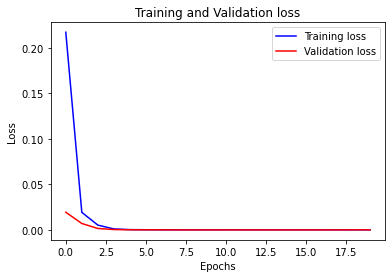

In [11]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
visualize_loss(history, "Training and Validation loss")

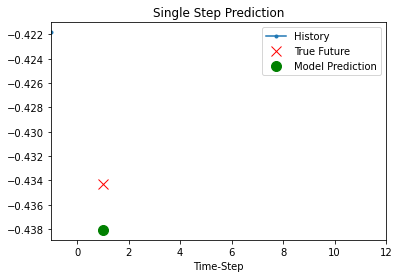

In [12]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

In [13]:
def denormalize(value):
    data_mean = mean[9]
    data_std = std[9]
    return value*data_std+data_mean

for x, y in dataset_val.take(1):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)[0]
    
    actualValue = x[0][:, 9].numpy()
    print("predicted denormalized:", denormalized_predictionData)
    print("             predicted:", predictionData[0])
    print("                actual:", actualValue)

# for x, y in datasetPredTest.take(1):
#     show_plot(
#         [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
#         1,
#         "Single Step Prediction",
#     )

predicted denormalized: [[3712.0298]]
             predicted: [[-0.4380771]]
                actual: [-0.43428471]


In [14]:
predTest = pd.read_csv('TestData/testData.csv',';')

featuresPredTest = predTest[titles]
predTestRange = int(featuresPredTest.shape[0])
featuresPredTest = normalize(featuresPredTest.values, predTestRange)
featuresPredTest = pd.DataFrame(featuresPredTest)
x_predTest = featuresPredTest.iloc[[i for i in range(predTestRange)]].values
y_predTest = featuresPredTest.iloc[0:][[9]]

datasetPredTest = keras.preprocessing.timeseries_dataset_from_array(
    x_predTest,
    y_predTest,
    sequence_length=1,
    sampling_rate=1,
    batch_size=1
)

for x, y in datasetPredTest.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)
    print("predicted denormalized:", denormalized_predictionData)
    print("             predicted:", predictionData)
    actualValue = x[0][:, 9].numpy()
    print("          actual value:", actualValue)

predicted denormalized: [[[4159.993]]]
             predicted: [[[-0.14033146]]]
          actual value: [-0.14352941]
predicted denormalized: [[[2316.95]]]
             predicted: [[[-0.7301439]]]
          actual value: [-0.73236802]
predicted denormalized: [[[3241.4858]]]
             predicted: [[[-0.43427297]]]
          actual value: [-0.43538855]
predicted denormalized: [[[2983.6267]]]
             predicted: [[[-0.5167933]]]
          actual value: [-0.51603383]
predicted denormalized: [[[13362.578]]]
             predicted: [[[2.804689]]]
          actual value: [2.78690273]
predicted denormalized: [[[4896.0103]]]
             predicted: [[[0.09520946]]]
          actual value: [0.10608696]
predicted denormalized: [[[2907.6052]]]
             predicted: [[[-0.5411218]]]
          actual value: [-0.52243425]
predicted denormalized: [[[1741.2593]]]
             predicted: [[[-0.914377]]]
          actual value: [-0.89941897]
predicted denormalized: [[[4580.547]]]
             pr

In [15]:
# for x,y in datasetPredTest.take(2):
#     print(x[0][0].numpy()[2])

In [16]:
model.save("kerasModel")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: kerasModel\assets


In [17]:
print(mean, std)

[2.09141054e+01 1.87665892e+08 2.04000000e+01 4.20000000e+00
 6.90600000e+00 1.13480000e+01 2.25900000e+02 2.25000000e+01
 4.50000000e+00 4.59850000e+03] [2.14813232e+00 1.70025508e+07 1.49666295e+00 1.46969385e+00
 3.90875939e-01 2.45470976e-01 8.59039580e+01 8.73212460e+00
 1.74642492e+00 3.12479511e+03]
